# NFL Why do players get injured?

![nfl](https://i2.wp.com/www.audiovisual451.com/wp-content/uploads/2020/03/nfl.jpg?w=696&ssl=1)

## Scope of the analysis

This exercise attempts to provide further insights on how NFL players get injured based on the data provided for this challenge. Most of the reasoning illustrated on this notebook and the subsequent conclusions are based on statistical hypothesis testing that will be also explained. The conclusions of the exercise will be listed at the end of the notebook. Let's get started!

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.weightstats import ttest_ind
import scipy.stats as stats
import itertools

## Data:

* InjuryRecord.csv: Contains information on 105 lower-limb injuries that occurred during regular season games over the two seasons.
* PlayList.csv: Details for the 267,005 player-plays that make up the dataset. Each play is indexed by PlayerKey, GameID, and PlayKey fields.
* PlayerTrackData.csv: Player level data that describes the location, orientation, speed, and direction of each player during a play recorded at 10 Hz.

In [ ]:
df_injuries = pd.read_csv('../input/nfl-playing-surface-analytics/InjuryRecord.csv')
df_playlist = pd.read_csv('../input/nfl-playing-surface-analytics/PlayList.csv')
df_player_tracks = pd.read_csv('../input/nfl-playing-surface-analytics/PlayerTrackData.csv')

## Exploring the datasets

We first read the three datasets provided and get some insights on the kind of data that we have.

In [ ]:
print('Number of injuries: %d' % len(df_injuries))
print('Number of plays: %d' % len(df_playlist))
print('Number of player tracks: %d' % len(df_player_tracks))

In [ ]:
df_injuries.info(verbose=True)
print('\n----------------------------------------------\n')
df_playlist.info(verbose=True)
print('\n----------------------------------------------\n')
df_player_tracks.info(verbose=True)

## Probability of getting injured

Initially, we explore the hypothesis that the probability of getting injured on the synthetic turf is higher. NO other variables are involved in this test. We compare the number of injuries in both surfaces and assess the significance level of the difference between probabilities.

In [ ]:
# Are there any duplicated IDs?
df_playlist['PlayKey'].duplicated().value_counts()

In [ ]:
# Are there any null values that need to be dropped?
df_playlist[['PlayerKey', 'GameID', 'PlayKey']].isna().sum()

In [ ]:
# Join playlist dataset and injury dataset using the keys from the playlist dataset
df_playlist_ext = pd.merge(df_playlist, df_injuries, how='left', on=['PlayerKey', 'GameID', 'PlayKey'])
#df_playlist_ext.info()

In [ ]:
# Create a new Boolean column indicating whether the player got injuried in that play.
df_playlist_ext['IsInjured'] = (df_playlist_ext['DM_M1']==1) | (df_playlist_ext['DM_M7']==1) | (df_playlist_ext['DM_M28']==1) | (df_playlist_ext['DM_M42']==1)
df_playlist_ext['IsInjured'].value_counts()

In [ ]:
# compute the injury probability for synthetic and natural turf
p_injury = df_playlist_ext[['FieldType', 'IsInjured']].groupby('FieldType').mean()['IsInjured']
p_injury

The null hypothesis **H0** states that there is no difference between the two population proportions, where the two populations or groups are the plays on synthetic and natural turf. More formally, this is stated as the difference between the two proportions being zero:  
  
*H0: p1-p2=0*  
  
We employ the **z-score test** for two population proportions. This test is generally used when you want to know whether two populations differ significantly on some characteristic (injuries). The equation is represented in the image below.

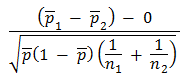

In [ ]:
p_null = df_playlist_ext[['FieldType', 'IsInjured']][df_playlist_ext['FieldType'] == 'Natural'].mean()[0]

n_plays_natural = df_playlist_ext.groupby('FieldType').size()[0]
n_plays_synthetic = df_playlist_ext.groupby('FieldType').size()[0]

div = np.sqrt(p_null * (1-p_null) * (1/n_plays_natural + 1/n_plays_synthetic))

#  compute z-score and p-value
z = (p_injury[1] - p_injury[0]) / div

print('The z-score is: {}'.format(z))
print('The p-value is: {}'.format(1-stats.norm.cdf(z)))

**Conclusion** With a 99% level of confidence we can **reject H0** and therefore we can confidently state that the probability of being injured on synthetic turf is higher than the probability of being injured on natural turf.  
  
Now the next question is to discover if any of the given variables affects the probability of getting injured on one or another surface. Additionally, we are also interested on whether they affect the duration of the injury.

## Pearson correlation between numerical variables

We explore the degree of correlation between the numerical variables provided.

In [ ]:
df_injuries_ext = pd.merge(df_injuries, df_playlist, how='inner', on=['PlayerKey', 'GameID', 'PlayKey'])

# Create a numerical variable from the duration
df_injuries_ext['Duration1'] = np.where(df_injuries_ext['DM_M1']>=1, 1, 0)
df_injuries_ext['Duration7'] = np.where(df_injuries_ext['DM_M7']>=1, 7, 0)
df_injuries_ext['Duration28'] = np.where(df_injuries_ext['DM_M28']>=1, 28, 0)
df_injuries_ext['Duration42'] = np.where(df_injuries_ext['DM_M42']>=1, 42, 0)
df_injuries_ext['Duration'] = df_injuries_ext[['Duration1', 'Duration7', 'Duration28', 'Duration42']].max(axis=1)
df_injuries_ext.drop(columns=['Duration1', 'Duration7', 'Duration28', 'Duration42'], inplace=True)
df_injuries_ext.head()

In [ ]:
df_corr = df_injuries_ext[['PlayerDay', 'PlayerGame', 'Temperature', 'PlayerGamePlay', 'Duration']].corr()

fig = plt.figure(figsize=(10,7))
ax = sns.heatmap(df_corr, annot=True, cmap=sns.diverging_palette(240, 10, n=9))
ax.set_title("Pearson Correlation between Variables");
plt.show()

**Conclusion**: Most of the numeric variables are uncorrelated with the exception of the day and game, which indicate the day of the season and game and are necessarily correlated. We also observe how the duration of the injury doesn't seem to be related with any of these variables.

## Correlation between categorical variables

In order to assess the relationship between categorical variables in our dataset, with special foculs on the surface of the field, we employ **Cramér's V**. In statistics, Cramér's V is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic and was published by Harald Cramér in 1946 https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V.

In [ ]:
# The following function was originally seen here: https://www.kaggle.com/phaethonprime/eda-and-logistic-regression

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [ ]:
cols = ['Surface', 'BodyPart', 'RosterPosition', 'StadiumType', 'FieldType', 'Weather', 'PlayType', 'Position', 'PositionGroup']
corr = np.zeros((len(cols),len(cols)))

# Apply previous function to calculate Cramer's V for each pair
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corr[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df_injuries_ext[col1], df_injuries_ext[col2]))
    corr[idx2, idx1] = corr[idx1, idx2]

In [ ]:
df_corr = pd.DataFrame(corr, index=cols, columns=cols)

# Plot the correlation matrix
fig = plt.figure(figsize=(10,7))
ax = sns.heatmap(df_corr, annot=True, cmap=sns.diverging_palette(240, 10, n=9))
ax.set_title("Cramer V Correlation between Variables");
plt.show()

**Conclusion**: The most interesting information in the above plot is the relationship between the surface and the weather. The rest of the meaningful correlations are either obvious or not interesting for this analysis.

## Statistical hypothesis testing

In this section, we statistically test the relationship between some of the variables f the dataset. We specifically try to identify conditions in which it is more likely to suffer an injury, or that the injury las a longer duration, based on the number of instances observed. 

### About statistical tests with categorical variables

The Chi-square test of independence measures whether there is a relationship between two categorical variables like this case (surface and duration). However, it comes with a series of assumptions. One of them is that the value of expected cells should be greater than 5 for at least 20% of the cells. This won't be the case for some of the test to be run in this analysis.

The alternative test when this condition is not fulfilled is the Fisher Exact Test, which is practically applied when the sample sizes are relatively small https://towardsdatascience.com/fishers-exact-test-from-scratch-with-python-2b907f29e593. Still, this test can only be conducted for tables of size 2x2. 

Since in our case we have larger tables as we will see below, we stick to the Chi-square test for this analysis. More information regarding how to perform this test in Python here https://pythonfordatascience.org/chi-square-test-of-independence-python/.

In [ ]:
# Plot the distribution of injuries per surface
sns.set(style="darkgrid")
ax = sns.countplot(x="Surface", data=df_injuries)
ax.set_title("Injury count on both surfaces");
plt.show()

### Relationship between the surface and duration of the injury

Does the surface of the turf affect the duration of the injury? Here, the **H0 (Null Hypothesis)** states that there is no relationship between variable one (surface) and variable two (duration), while the **H1 (Alternative Hypothesis)** says that there is a relationship between them.

We **first** consider the duration as a categorical variable. Thus, when testing the data, the cells should represent counts of cases.

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x="Duration", data=df_injuries_ext)
plt.show()

In [ ]:
crosstab = pd.crosstab(df_injuries_ext['Surface'], df_injuries_ext['Duration'])
crosstab

In [ ]:
ret = stats.chi2_contingency(crosstab)
print('Pearson Chi-square = %.3f' % ret[0])
print('p-value = %.3f > 0.05' % ret[1])
print('We cannot reject H0. There is no relationship between Surface and Duration')

**Second**, we treat the duration as a numerical variable by making the assumption that the player was injuried the exact number of days indicated in the database. Then, we test if the duration is signifficantly higher on synthetic turf. The plot indicates that indeed it is higher, but we need to assess whether this difference is statistically significant.

In [ ]:
# Show each observation with a scatterplot
sns.set(style="darkgrid")
sns.stripplot(x="Duration", y="Surface", order=['Natural','Synthetic'], data=df_injuries_ext, alpha=.50)
sns.pointplot(x="Duration", y="Surface", order=['Natural','Synthetic'], data=df_injuries_ext, palette="dark", markers="d")
plt.show()

In [ ]:
# Get each position independently
d_natural = df_injuries_ext['Duration'][df_injuries_ext['Surface']=='Natural']
d_synthetic = df_injuries_ext['Duration'][df_injuries_ext['Surface']=='Synthetic']

# Example of how it would be done for only two groups
ret = stats.ttest_ind(d_natural, d_synthetic)
print('Independent t-test = %.3f' % ret[0])
print('p-value = %.3f > 0.05' % ret[1])
print('We cannot reject H0. There is no relationship between Surface and Duration')

**Conclusion**: Although there is an interesting effect indicating that the duration may be longer if the injury was suffered on synthetic turf, there are no statistical evidence tu support that affirmation. However, given the little data available, it is hard to say for certain. We need to collect more data!

### Relationship between the weather and the surface

Following on the correlation observed between weather and surface. Could it be that bad weather in combination with a specific turf surface lead to a higher probability of getting injured? This is the hypothesis that we are following in this section. The **Null Hypothesis (H0)** states that there is no relationship between surface and weather.

In [ ]:
df_injuries_ext = df_injuries_ext.replace('Mostly sunny', 'Sunny')
df_injuries_ext = df_injuries_ext.replace('Mostly Sunny', 'Sunny')
df_injuries_ext = df_injuries_ext.replace('Clear Skies', 'Clear')
df_injuries_ext = df_injuries_ext.replace('Controlled Climate', 'Clear')
df_injuries_ext = df_injuries_ext.replace('Clear and warm', 'Clear')
df_injuries_ext = df_injuries_ext.replace('Fair', 'Clear')
df_injuries_ext = df_injuries_ext.replace('Clear skies', 'Clear')
df_injuries_ext = df_injuries_ext.replace('Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.', 'Rain')
df_injuries_ext = df_injuries_ext.replace('Coudy', 'Cloudy')
df_injuries_ext = df_injuries_ext.replace('Mostly cloudy', 'Cloudy')
df_injuries_ext = df_injuries_ext.replace('Cloudy and Cool', 'Cloudy')
df_injuries_ext = df_injuries_ext.replace('Sun & clouds', 'Partly Cloudy')
df_injuries_ext = df_injuries_ext.replace('Light Rain', 'Rain')
df_injuries_ext = df_injuries_ext.replace('Rain shower', 'Rain')
df_injuries_ext = df_injuries_ext.replace('Cloudy, 50% change of rain', 'Rain')
df_injuries_ext = df_injuries_ext.replace('Indoors', 'Indoor')

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x="Weather", data=df_injuries_ext)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()

In [ ]:
crosstab = pd.crosstab(df_injuries_ext['Surface'], df_injuries_ext['Weather'])
crosstab

In [ ]:
ret = stats.chi2_contingency(crosstab)
print('Pearson Chi-square = %.3f' % ret[0])
print('p-value = %.3f < 0.05' % ret[1])
print('We can reject H0. There is a relationship between Surface and Weather')

In fact we observe an effect on the weather on the surface of the injuries. However, we do not know for which weather in concrete. I have the suspicion though, that this effect is caused by the number of **Indoor** injuries (8 to 0).

In [ ]:
df_aux = df_injuries_ext[df_injuries_ext['Weather'] != 'Indoor']
crosstab = pd.crosstab(df_aux['Surface'], df_aux['Weather'])
ret = stats.chi2_contingency(crosstab)
print('Pearson Chi-square = %.3f' % ret[0])
print('p-value = %.3f < 0.05' % ret[1])
print('We cannot reject H0.')

**Conclusion** Bingo! the effect disappears when removing indoor weather from the equation. We don't know beforehand whether all indoor stadiums have a synthetic surface or this is not the case. Therefore, We cannot jump into the conclusion that playing indoors increases the chance of suffering an injury. This is something that has to be studied more in detail. 

### Relationship betweein the surface and the body part

Does the surface of the turf affect the part where the player was injured? Here, the **H0 (Null Hypothesis)** states that there is no relationship between variable one (surface) and variable two (body part), while the **H1 (Alternative Hypothesis)** says that there is a relationship between them.

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x="BodyPart", data=df_injuries_ext)
plt.show()

In [ ]:
crosstab = pd.crosstab(df_injuries_ext['Surface'], df_injuries_ext['BodyPart'])
crosstab

In [ ]:
ret = stats.chi2_contingency(crosstab)
print('Pearson Chi-square = %.3f' % ret[0])
print('p-value = %.3f > 0.05' % ret[1])
print('We cannot reject H0. There is no relationship between Surface and BodyPart')

In [ ]:
crosstab_heel_toe = crosstab[['Ankle', 'Foot']]
ret = stats.fisher_exact(crosstab_heel_toe)
print('Pearson Chi-square = %.3f' % ret[0])
print('p-value = %.3f > 0.05' % ret[1])
print('We cannot reject H0. There is no relationship between Surface and BodyPart for the specific case of heels and toes')

**Conclusion**: There is no statistical evidence supporting that the surface has an effect on the number of injuries suffered for any specific part of the body.

### Considering the relationship between player position and surface

Although we have already observed that these two variables are not correlated, we still want to investigate if players playing in a specific position get injured more often on synthetic turf (our **Null Hypothesis H0**).

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x="PositionGroup", data=df_injuries_ext)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

In [ ]:
crosstab = pd.crosstab(df_injuries_ext['Surface'], df_injuries_ext['PositionGroup'])
crosstab

In [ ]:
ret = stats.chi2_contingency(crosstab)
print('Pearson Chi-square = %.3f' % ret[0])
print('p-value = %.3f > 0.05' % ret[1])
print('We cannot reject H0. There is no relationship between Surface and BodyPart')

**Conclusion**: Indeed, there is no evidence regarding the player position having an effect on the injuries per surface.

### Interaction between surface and temperature

The degree of relationship for these two variables is unexplored in the correlation analysis as one is numerical (temperature) and the other one is categorical (surface). Let's start by cleaning the temperature data.

In [ ]:
# We have some values -999 which are clear NaNs. Replace them
df_aux = df_injuries_ext[df_injuries_ext['Temperature'] != -999]

In [ ]:
sns.set(style="darkgrid")
sns.stripplot(x="Temperature", y="Surface", data=df_aux, alpha=.70)
sns.pointplot(x="Temperature", y="Surface", data=df_aux, palette="dark", markers="d")
plt.show()

At first sight, we don't observe a clear effect of the temperature on the surface of the injuries. Still, we have to test it statistically.  
  
As the temperature is a numerical variable, we cannot perform the same type of analysis as before. In this case, an **two-sided Student's t-test** for independent samples should be carried out. This statistical test assess whether two independent samples have identical average (expected) values (our **null hypothesis or H0**). https://en.wikipedia.org/wiki/Student%27s_t-test

In [ ]:
temp_natural = df_aux['Temperature'][df_aux['Surface']=='Natural']
temp_synth = df_aux['Temperature'][df_aux['Surface']=='Synthetic']

ret = stats.ttest_ind(temp_natural, temp_synth)
print('Independent t-test = %.3f' % ret[0])
print('p-value = %.3f > 0.05' % ret[1])
print('We cannot reject H0. There is no relationship between Surface and Temperature')

**Conclusion**: The temperature has no effect on the injuries per surface.

## Path analysis for injured players

We are also provided with the path followed by the player during the entire course of the play where he got injured. In this regard, we will be analyzing the effect of two specific variables on the amount of injuries suffered for any specific turf. One is the **average speed** of the play and the second is the **amount of rotation**.

In order to get to the bottom of this interactions, we would have to consider with special interest the last part of the player movement. This analysis is outside the scope of this notebook, however, the same methodology would apply.

In [ ]:
df_tracks_ext = pd.merge(df_player_tracks, df_injuries, on='PlayKey', how='inner')
df_tracks_ext.head()

In [ ]:
# Scatter plot for one example play (using 39678-2-1, 47813-8-19 and 31070-3-7 as examples)
df_track = df_tracks_ext[df_tracks_ext['PlayKey']=='47813-8-19']
turf_img = plt.imread('../input/customimgs/nfl-turf.jpg')

fig = plt.figure(figsize=(10,6))
implot = plt.imshow(turf_img, extent=[-10, 120, -10, 54])
sns.scatterplot(x='x', y='y', hue='PlayKey', data=df_track)
plt.show()

In [ ]:
# And scatter plot for every play that resulted into an injury
fig = plt.figure(figsize=(10,6))
implot = plt.imshow(turf_img, extent=[-10, 120, -10, 54])
sns.scatterplot(x='x', y='y', hue='PlayKey', data=df_tracks_ext, legend=False)
plt.show()

### Analyzing the average speed

We look into the average speed of the play and its influence on the injuries suffered for each specific turf. We observe the degree of relationship between the speed and the duration of the injury as well.

In [ ]:
# Obtain average speed for each play
df_speed = df_tracks_ext.groupby('PlayKey')['s'].mean()
df_speed_ext = pd.merge(df_speed, df_tracks_ext[['PlayKey', 'Surface']], on='PlayKey', how='inner')
df_speed_ext = df_speed_ext.drop_duplicates().reset_index()

In [ ]:
# Sort the dataframe by surface
df_natural = df_speed_ext.loc[df_speed_ext['Surface'] == 'Natural']
df_synthetic = df_speed_ext.loc[df_speed_ext['Surface'] == 'Synthetic']

# Plot distribution of velocities for both groups
sns.distplot(df_natural['s'], bins=10)
sns.distplot(df_synthetic['s'], bins=10)
plt.show()

In [ ]:
sns.set(style="darkgrid")
sns.stripplot(x="s", y="Surface", data=df_speed_ext, alpha=.70)
sns.pointplot(x="s", y="Surface", data=df_speed_ext, palette="dark", markers="d")
plt.show()

**Conclusion:** In light of the figures above, we do not need to run the statistican tests to observe that the speed for both groups is nearly identical. Our data indicates that **average** speed does not affect the probability of getting injured on one specific surface.  
  
We are also interested on the relationship between the speed and the length of the injury. We observe this through the Pearson correlation between variables.

In [ ]:
df_aux = pd.concat([df_speed_ext, df_injuries_ext['Duration']], axis=1)
corr = df_aux['s'].corr(df_aux['Duration'])
print('Pearson correlation: ', corr)
print('Degrees of freedom: ', (len(df_speed_ext.index)-2) )

**Conclusion:** The correlation is not particularly high, although it has some degree of signifficancy according to this table: https://www.statisticssolutions.com/table-of-critical-values-pearson-correlation/. Therefore there is a mild tendency that higher speed may lead to injuries that last longer.

### Analyzing the amount of rotation

In this exercise, we calculate the amount of rotation as the sum of the differentials between the rotations at each specific time step, for each particular play. In this spirit, we initially consider both the **'o'** and **'dir'** column. We don't know how these orientation values were registered, although it is assumed a certain degree of noise that is neglected for this exercise but should be taken into account for deeper analyses.

In [ ]:
area = 4 * df_track['s']**2

fig = plt.figure(figsize=(8, 20))

# Plotting direction and orientation in polar coordinates, for one specific play
ax = plt.subplot(1, 2, 1, projection='polar')
plt.scatter(df_track['dir'], df_track['s'], s=area, alpha=0.50, color='orange')
ax.set_title('Speed and direction.')
ax = plt.subplot(1, 2, 2, projection='polar')
plt.scatter(df_track['o'], df_track['s'], s=area, alpha=0.50, color='green')
ax.set_title('Speed and orientation.')
plt.show()

In [ ]:
# To get the amount of rotation from orientation we substract the current row with the previous row
df_tracks_ext['o_diff'] = df_tracks_ext['o'].diff()
df_orientation = df_tracks_ext.groupby('PlayKey')['o_diff'].sum().abs()

In [ ]:
# To get the amount of rotation from direction we substract the current row with the previous row
df_tracks_ext['dir_diff'] = df_tracks_ext['dir'].diff()
df_direction = df_tracks_ext.groupby('PlayKey')['dir_diff'].sum().abs()

In [ ]:
# Merge the dataframes
df_orientation_ext = pd.merge(df_orientation, df_tracks_ext[['PlayKey', 'Surface']], on='PlayKey', how='inner')
df_orientation_ext = df_orientation_ext.drop_duplicates().reset_index()
df_direction_ext = pd.merge(df_direction, df_tracks_ext[['PlayKey', 'Surface']], on='PlayKey', how='inner')
df_direction_ext = df_direction_ext.drop_duplicates().reset_index()

Somehow surprisingly, these two measures are not highly correlated, as we can see below. The challenge advises not to consider the orientation as a reliable indicator as the measurement varied over seasons. We therefore **won't consider** the orientation for further analysis and analyze the amount of rotation based on the direction.

In [ ]:
df_direction_ext['dir_diff'].corr(df_orientation_ext['o_diff'])

In [ ]:
# Plot conditional distribution
sns.set(style="darkgrid")
ax = sns.stripplot(x="dir_diff", y="Surface", data=df_direction_ext, alpha=.70)
sns.pointplot(x="dir_diff", y="Surface", data=df_direction_ext, palette="dark", markers="d")
ax.set_title('Conditional distribution, direction')
plt.show()

In [ ]:
temp_natural = df_direction_ext['dir_diff'][df_direction_ext['Surface']=='Natural']
temp_synth = df_direction_ext['dir_diff'][df_direction_ext['Surface']=='Synthetic']

# Student's t-test
ret = stats.ttest_ind(temp_natural, temp_synth)
print('Independent t-test = %.3f' % ret[0])
print('p-value = %.3f > 0.05' % ret[1])
print('We cannot reject H0. There is no relationship between Surface and Temperature')

In [ ]:
df_aux = pd.concat([df_direction_ext, df_injuries_ext['Duration']], axis=1)
corr = df_aux['dir_diff'].corr(df_aux['Duration'])
print('Pearson correlation: ', corr)
print('Degrees of freedom: ', (len(df_speed_ext.index)-2) )

**Conclusion:** Both the statistical test and the correlation suggest that the amount of rotation, as considered in this analysis, does not have an effect on the surface nor is related with the duration of the injury

## Final remarks

After an exhaustive analysis on the data provided we found the following conclusions, supported by statistical evidence:
* There is a higher probability of getting injured on synthetic turf.
* The average speed of the play is correlated with the duration of the injury.

We also found insights on the following effects that should be investigated more carefully:
* Getting injuried on synthetic turf may lead to being injured for a larger period of time.
* The weather may affect the probability of getting injured when playing indoors.

Thanks for following this notebook till the end :)